In [87]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy.ndimage import maximum_filter
from scipy.interpolate import interp1d
from scipy.optimize import minimize
from scipy.stats import chisquare


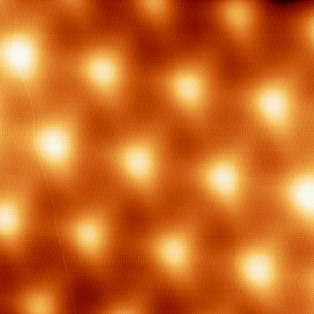

In [88]:
im = Image.open("data2.jpg")
im

In [89]:
# This function takes three primitive vector a_1,a_2,a_3 which are calculated from the real space
# STM images. The primitive vectors are then fourier transformed in reciprocal/K-space/momentum space vector b1,b2,b3


def reciprocal_space_transform(a_1x, a_1y, a_2x, a_2y):
    
    # transformation from real space onto k-space 
    b_1x = (2*np.pi) * a_2y / ( (a_1x*a_2y) - (a_1y*a_2x) )
    b_1y = (2*np.pi) * (-1)*a_2x / ( (a_1x*a_2y) - (a_1y*a_2x) )

    b_2x = (2*np.pi) * (-1)*a_1y / ( (a_1x*a_2y) - (a_1y*a_2x) )
    b_2y = (2*np.pi) * a_1x / ( (a_1x*a_2y) - (a_1y*a_2x) )
    
    b1 = np.array([b_1x,b_1y])   
    b2 = np.array([b_2x,b_2y])
    
    # Defining b3 as superposition of b1 and b3 vectors
    b3_x = b1[0] - b2[0]
    b3_y = b1[1] - b2[1]
    
    b3 = np.array([b3_x,b3_y])
    
    return b1,b2,b3



In [114]:
################ This function simulates the twisted graphene lattice structure in 2D k-space ####################

########## Inputs: ##########
# alpha : lattice constant (0.246 nm for Graphene)
# sigma : poisson ratio of material (0.16 for Graphene)
# epsilon : strain percentage
# theta_s : applied strain angle
# theta_t : Graphene stack twist angle
# theta_g : taking initial STM orientation into account by rotating all points 

########### Outputs: ##########
# 2 n-length lists corresponding to list of x value and y value coordinates for 3 simulated lattice vectos

def test_sim(alpha, sigma, epsilon, theta_s,theta_t, theta_g):
    
    origin = [0,0]
    a_0 = alpha
    #a_0 = 0.246 * (10**(-9)) #meters
    k = 4*(np.pi) / ( np.sqrt(3) * a_0)
    
    ################# define some essential and simple functions ###########
    
    def deg_to_rad(degree):
        return degree * np.pi/180
    
    def rot_matrix(angle): # angle should be in rads
        ret_mat = np.array([[np.cos(angle),(-1)*np.sin(angle)],[np.sin(angle),np.cos(angle)]])
        return ret_mat

    ################ Define k-space lattice sites #############

    k_1 = np.array([1,0]) * k
    k_1 = k_1.reshape(2,1)


    k_2 = np.array([np.cos(deg_to_rad(60)), np.sin(deg_to_rad(60))]) * k
    k_2 = k_2.reshape(2,1)

    k_3 = np.array([np.cos(deg_to_rad(120)), np.sin(deg_to_rad(120))]) * k
    k_3 = k_3.reshape(2,1)
    
    k_x_vals = [k_1[0],k_2[0],k_3[0],-k_1[0],-k_2[0],-k_3[0]]
    k_y_vals = [k_1[1],k_2[1],k_3[1],-k_1[1],-k_2[1],-k_3[1]]
    
    ################ k prime defintions #############
    
    theta_twist = theta_t
    theta_twist_rad = deg_to_rad(theta_twist)
    rotation_matrix = np.array([[np.cos(theta_twist_rad),(-1)*np.sin(theta_twist_rad)],[np.sin(theta_twist_rad),np.cos(theta_twist_rad)]])

    # rotation_matrix

    k_1_prime = np.matmul(rotation_matrix,k_1)


    k_2_prime= np.matmul(rotation_matrix,k_2)


    k_3_prime= np.matmul(rotation_matrix,k_3)
    
    origin = [0,0]
 
    k_prime_x_vals = [k_1_prime[0],k_2_prime[0],k_3_prime[0],-k_1_prime[0],-k_2_prime[0],-k_3_prime[0]]
    k_prime_y_vals = [k_1_prime[1],k_2_prime[1],k_3_prime[1],-k_1_prime[1],-k_2_prime[1],-k_3_prime[1]]
    
    ################# define moire wavelengths ##############
    
    K_1 = k_1_prime - k_1

    K_2 = k_2_prime - k_2

    K_3 = k_3_prime - k_3
    
    ################ define strain matrix and strain wave vectors ###########

    E_matrix = np.array([[1/(1+epsilon), 0],[0, 1/(1-(sigma*epsilon))]])
    
    S_matrix = rot_matrix(-deg_to_rad(theta_s)) @ E_matrix @ rot_matrix(deg_to_rad(theta_s))
    # Several corrections:
    # 1) The inputs of rot_matrix should be in rads;
    # 2) The first matrix is the inverse/transpose of the last matrix. Due to the structure of the rotational matrix it can be achieved by theta_s -> -theta_s;
    # 3) Matrix multiplication operator "@" should be used instead of element-wise multiplication "*"
    
    k_1s = np.matmul(S_matrix, k_1)

    k_2s = np.matmul(S_matrix, k_2)

    k_3s = np.matmul(S_matrix, k_3)
    
    k_xs_vals = [k_1s[0],k_2s[0],k_3s[0],-k_1s[0],-k_2s[0],-k_3s[0]]
    k_ys_vals = [k_1s[1],k_2s[1],k_3s[1],-k_1s[1],-k_2s[1],-k_3s[1]]

    K_1s = k_1_prime - k_1s

    K_2s = k_2_prime - k_2s

    K_3s = k_3_prime - k_3s
    
    K_xs_vals = [K_1s[0],K_2s[0],K_3s[0],-K_1s[0],-K_2s[0],-K_3s[0]]
    K_ys_vals = [K_1s[1],K_2s[1],K_3s[1],-K_1s[1],-K_2s[1],-K_3s[1]]
    rotate_x_points = []
    rotate_y_points = []

    for i in range(len(K_xs_vals)): # correction: the overall rotation should be applied to "K" instead of "k" vectors!
        point = [K_xs_vals[i][0],K_ys_vals[i][0]] # K_xs_vals[i][0] is a number instead of an 1*1 array
        new_x, new_y = rotate(origin,point, deg_to_rad(theta_g)) # the angle of function "rotate" should be in rads
        rotate_x_points.append(new_x)
        rotate_y_points.append(new_y)
       
    
    ####################### plot k and k prime points with and without strain ################
    
#     plt.scatter(k_prime_x_vals,k_prime_y_vals,color = "red", label = "twisted lattice")
#     plt.scatter(k_x_vals,k_y_vals,color = "blue", label = "primary lattice")
#     plt.scatter(origin[0],origin[1],color = "green", label = "origin")


    ############# Main Plot #############
#     plt.title("Simulated k-space lattice vectors")
#     for i in range(1,len(k_xs_vals)+1):
        
#         labell = "k"+str(i)+"lattice w/strain"
#         plt.scatter(rotate_x_points[i-1],rotate_y_points[i-1], label = labell)
#         plt.legend()
#     plt.show()
    
    
    
#     plt.scatter(k_x_vals,k_y_vals,color = "blue")
#     plt.scatter(origin[0],origin[1],color = "green")
    return rotate_x_points,rotate_y_points 

In [113]:
import math

def rotate(origin, point, angle):
    """
    Rotate a point counterclockwise by a given angle around a given origin.

    The angle should be given in radians.
    """
    ox, oy = origin
    px, py = point

    qx = ox + math.cos(angle) * (px - ox) - math.sin(angle) * (py - oy)
    qy = oy + math.sin(angle) * (px - ox) + math.cos(angle) * (py - oy)
    return qx, qy

In [90]:
def threshold(image_array, thresh_val):
    
    shape = image_array.shape
    
    num_rows = shape[0]
    num_cols = shape[1]

    for j in range(num_cols):
       for i in range(num_rows):
         if image_array[i,j] < thresh_val:
           image_array[i,j] = 0

    return image_array


In [118]:
# pixel_scale = 7.75
# threshold_val = 200


def strainMapper(input_image_loc, pixel_scale, threshold_val):
    
    ################ Define scale of pixel to nm conversion
    pixel_to_nm_conversion = pixel_scale
    
    ################ Convert image to 2D numpy array format
    im = input_image_loc
    im_bw = im.convert(mode="L") 
    im_dat = im_bw.getdata() 
    width, height = im_dat.size[0], im_dat.size[1]
    im_dat = np.array(im_dat)
    im_dat = im_dat.reshape(height, width)
    
    ################ Apply threshold
    im_threshed = threshold(im_dat,threshold_val)
    
    ################ Apply gaussian max filter
    temp_im = list(maximum_filter(im_threshed, size=(5,5)))
    
    ################ Find lattice peaks
    shape_dat = im_dat.shape
    num_rows_dat = shape_dat[0]
    num_cols_dat = shape_dat[1]

    temp_im_arr = np.asarray(temp_im).reshape(num_rows_dat,num_cols_dat)
    row_arr = []
    col_arr = []

    for rows in range(num_rows_dat):
        for col in range(num_cols_dat):
            if (temp_im_arr[rows,col] == im_threshed[rows,col] and temp_im_arr[rows,col] != 0 and temp_im_arr[rows,col] > 225):
                row_arr.append(rows)
                col_arr.append(col)


    ############### Isolating peak coordinates 
    x_point_all = []
    y_point_all = []

    # This loop makes sure that points that are closer than 20 units in both x and y values are isolated so
    # we have one point corresponding to each lattice 

    for i in range(len(row_arr)):
        if(i != len(row_arr)-1):
            if(row_arr[i+1] - row_arr[i] > 20 or col_arr[i+1] - col_arr[i] > 20):
                x_point_all.append(row_arr[i])
                y_point_all.append(col_arr[i])
                x_point_all.append(row_arr[i+1])
                y_point_all.append(col_arr[i+1])
        if(i == len(row_arr)):
            if(row_arr[i] - row_arr[0] > 20 or col_arr[i] - col_arr[0] > 20):
                x_point_all.append(row_arr[i])
                y_point_all.append(col_arr[i])
                x_point_all.append(row_arr[i])
                y_point_all.append(col_arr[i])


    ################ Averaging peaks ##########    
    single_centers_x = []
    single_centers_y = []


    for i in range(len(y_point_all)):
        if(i != len(y_point_all)-1):
            if(x_point_all[i+1] - x_point_all[i] < 20 and y_point_all[i+1] - y_point_all[i] < 20):
                single_centers_x.append( (x_point_all[i]+x_point_all[i+1]) /2) 
                single_centers_y.append( (y_point_all[i]+y_point_all[i+1]) /2)
        if(i == len(y_point_all)):
            if(x_point_all[i] - x_point_all[0] < 20 and y_point_all[i] - y_point_all[0] < 20):
                single_centers_x.append( (x_point_all[i]+x_point_all[0]) / 2)
                single_centers_y.append( (y_point_all[i]+y_point_all[0]) / 2)


    print("############# lattice sites #################")
    
    sorted_x = np.sort(np.array(single_centers_y) )
#     print(sorted_x)
#     minimum_x = np.min(single_centers_y)
    
    for i in range(len(single_centers_y)):
        print(single_centers_y[i],single_centers_x[i])
        if (single_centers_y[i] == sorted_x[0]):
            origin = [single_centers_y[i],single_centers_x[i]]
        if (single_centers_y[i] == sorted_x[1]):
            p1 = [single_centers_y[i],single_centers_x[i]]
        if (single_centers_y[i] == sorted_x[2]):
            p2 = [single_centers_y[i],single_centers_x[i]]
    
#     print(origin)
#     print(p1)
#     print(p2)


#     plt.scatter(single_centers_y,single_centers_x)
#     plt.gca().invert_yaxis()
#     plt.grid()
#     plt.show()

#     O = np.array(origin) / pixel_to_nm_conversion
#     a1 = np.array(p1) / pixel_to_nm_conversion
#     a2 = np.array(p2) / pixel_to_nm_conversion
#     single_centers_y_nm = np.array(single_centers_y) / pixel_to_nm_conversion
#     single_centers_x_nm = np.array(single_centers_x) / pixel_to_nm_conversion

    
    O = np.array(origin)
    a1 = np.array(p1) 
    a2 = np.array(p2)
    single_centers_y_nm = np.array(single_centers_y) 
    single_centers_x_nm = np.array(single_centers_x) 
    
    X = O[0]
    Y = O[1]

    a1_vec = a1 - O
    a2_vec = a2 - O



    # Directional vectors
    U = [a1_vec[0]]  
    V = [a1_vec[1]]  

    W = [a2_vec[0]]  
    Z = [a2_vec[1]]  


    left = np.min(single_centers_y_nm) 
    right = np.max(single_centers_y_nm) 
    bottom = np.max(single_centers_x_nm)
    top = np.min(single_centers_x_nm) 

    # # Creating plot
    plt.quiver(X, Y, U, V, color='b', units='xy', scale=1, label = "a1")
    plt.quiver(X, Y, W, Z, color='purple', units='xy', scale=1, label = "a2")


    UT = U[0] + W[0]
    VR = V[0] + Z[0]
    plt.quiver(X, Y, UT, VR, color='magenta', units='xy', scale=1, label = "a1+a3")


    plt.scatter(single_centers_y_nm,single_centers_x_nm,c='r', marker = "+")
    plt.scatter(X,Y,color = "g")
    img_lim = plt.imshow(im_threshed, interpolation = "nearest", cmap = "inferno",vmin = np.min(im_threshed), vmax=np.max(im_threshed))
    clb = plt.colorbar(img_lim, fraction=0.03, pad=0.08) # Use these as your
    plt.gca().invert_yaxis()
    plt.legend()
    
    plt.ylabel("nm")
    plt.xlabel("nm")
    
    plt.show()
    
    b1,b2,b3 = reciprocal_space_transform(a1_vec[0], a1_vec[1], a2_vec[0], a2_vec[1])

    plt.scatter(0,0,label = "origin")

    plt.scatter(b1[0],b1[1],label = "k1")
    plt.scatter(b2[0],b2[1],label = "k2")
    plt.scatter(b3[0],b3[1],label = "k3")

    plt.scatter(-b1[0],-b1[1])
    plt.scatter(-b2[0],-b2[1])
    plt.scatter(-b3[0],-b3[1])
    plt.show()
    
#     plt.set_aspect(1)

    exp_dat = np.array([ [b1[0],b1[1]] , [b3[0],b3[1]], [b2[0],b2[1]] ])
    test_param = [0.005,60,1.1,-30]
    fixed_param = [0.246, 0.16] 


    def my_least_squared(a_parameters, a_fixed):  #, a_experimentalPoints):

        a_experimentalPoints = np.array([ [-b1[0],-b1[1]] , [-b3[0],-b3[1]], [b2[0],b2[1]] ])
        a_experimentalPoints_x = np.array([-b1[0],-b3[0],b2[0]])
        a_experimentalPoints_y = np.array([-b1[1],-b3[1],b2[1]])

    # simPoints are determined by both fixed parameters (alpha, sigma) and variable ones (epsilon, theta_s, theta_t, theta_g)
        totSimPointsx,totSimPointsy = test_sim(a_fixed[0], a_fixed[1], a_parameters[0], a_parameters[1],a_parameters[2],a_parameters[3])
    #     simPoint1 = [simPointsx[0],simPointsy[0]]
    #     simPoint2 = [simPointsx[1],simPointsy[1]]
    #     simPoint3 = [simPointsx[2],simPointsy[2]]

        simPointsx = np.asarray(totSimPointsx[:3])
        simPointsy = np.asarray(totSimPointsy[:3])

    #     print(a_experimentalPoints_x)
    #     print(simPointsx)
    #     simulatedPoints = np.array([ simPoint1, simPoint2, simPoint3])


    #     chiSquared = np.sum( (a_experimentalPoints - simulatedPoints)**2 / simulatedPoints )
    #     my_least_sq = np.sum( (a_experimentalPoints_x - simPointsx) * (a_experimentalPoints_y - simPointsy)  ) / np.sum( (a_experimentalPoints_x - simPointsx)**2 )
        my_least_sq = np.sum( (a_experimentalPoints_x - simPointsx)**2 + (a_experimentalPoints_y - simPointsy)**2 ) 
    # For least squared minimization we can just add the squares of each distance together: the calculation is easier without doing the extra square root!


        return my_least_sq

    
    res = minimize(my_least_squared, test_param, fixed_param)
    opt_param = res.x
    print(res.message)
    print(res.x)
    
    opt_x,opt_y = test_sim(fixed_param[0],fixed_param[1],opt_param[0],opt_param[1],opt_param[2],opt_param[3])
    plt.scatter(opt_x[0],opt_y[0],label = "sim k1")
    plt.scatter(opt_x[1],opt_y[1],label = "sim k2")
    plt.scatter(opt_x[2],opt_y[2],label = "sim k3")
    # plt.scatter(-a[0],-b[0],label = "sim -k1")
    # plt.scatter(-a[1],-b[1],label = "sim -k2")
    # plt.scatter(-a[2],-b[2],label = "sim -k3")
    plt.legend()

############# lattice sites #################
102.5 72.5
188.0 88.0
273.0 104.0
54.0 144.5
140.0 161.5
222.0 179.0


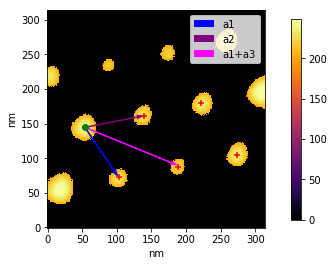

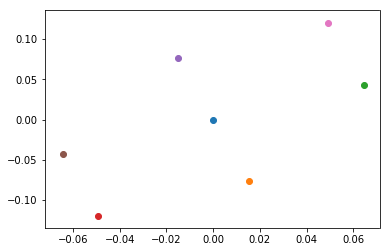

Optimization terminated successfully.
[4.58802994e-03 1.20266788e+02 1.60948773e-05 8.12557473e+00]


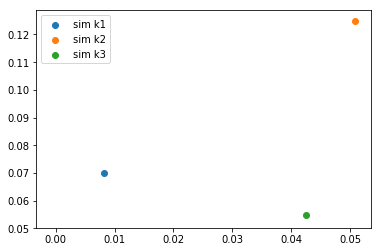

In [119]:
strainMapper(im,7.75,200)